In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from RS.core import *
from RS.model import *
import lovasz_loss as Lov

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

In [ ]:
from fastai.vision.all import *

In [ ]:
# torch.cuda.set_device(1)

In [ ]:
# df=pd.read_csv('./train.csv')
imgs=get_files('/home/staff/xin/Downloads/tianchi/train/',extensions='.tif')
df=pd.DataFrame({'path':imgs})

In [ ]:
df.head()

,path
0,/home/staff/xin/Downloads/tianchi/train/003957.tif
1,/home/staff/xin/Downloads/tianchi/train/003103.tif
2,/home/staff/xin/Downloads/tianchi/train/002664.tif
3,/home/staff/xin/Downloads/tianchi/train/000901.tif
4,/home/staff/xin/Downloads/tianchi/train/002469.tif


In [ ]:
# db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
#                        TransformBlock(type_tfms=partial(RsMask.create)),
#                       ),
#                get_x=ColReader('path'),
#                get_y=ColReader('path'),
#                splitter=ColSplitter('valid'),
#                item_tfms=[aug,aug2]
#               )
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_x=ColReader('path'),
               get_y=ColReader('path'),
               splitter=RandomSplitter(valid_pct=0.2,seed=10),
               item_tfms=[aug,aug2]
              )

# db.summary(source=df)

In [ ]:

dls = db.dataloaders(source=df,bs=16, num_workers=8)


In [ ]:
model=ResNestedUNet(num_classes=10,input_channels=4,deep_supervision=False)
apply_init(model)

In [ ]:
# loss=OhemCrossEntropy()

In [ ]:
def mIOU( pred,label, num_classes=10):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()
    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        if sem_class!=30:
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [ ]:
class newloss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss = CrossEntropyLossFlat(axis=1)
    def forward(self, input, target):
        return self.loss(RsImage(input),RsImage(target.long()))

In [ ]:
class OhemCrossEntropy(nn.Module): 
    def __init__(self, ignore_label=-1, thres=0.7, 
        min_kept=100000, weight=None): 
        super(OhemCrossEntropy, self).__init__() 
        self.thresh = thres
        self.min_kept = max(1, min_kept)
        self.ignore_label = ignore_label 
        self.weight=weight
        self.criterion = nn.CrossEntropyLoss(weight=weight, 
                                             ignore_index=ignore_label, 
                                             reduction='none') 
    
    def forward(self, score, target, **kwargs):
        target=RsImage(target.long())
        pred = F.softmax(score, dim=1)
        pixel_losses = self.criterion(score, target).contiguous().view(-1)
        mask = target.contiguous().view(-1) != self.ignore_label         
        
        tmp_target = target.clone() 
        tmp_target[tmp_target == self.ignore_label] = 0 
        pred = pred.gather(1, tmp_target.unsqueeze(1)) 
        pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()
        min_value = pred[min(self.min_kept, pred.numel() - 1)] 
        threshold = max(min_value, self.thresh) 
        
        pixel_losses = pixel_losses[mask][ind]
        pixel_losses = pixel_losses[pred < threshold] 
#         iouloss=Lov.lovasz_softmax(score,target,class_weight=self.weight)
        return pixel_losses.mean()

In [ ]:
class Lovloss(nn.Module): 
    def __init__(self, ignore_label=-1, thres=0.7, 
        min_kept=100000, weight=None): 
        super(Lovloss, self).__init__() 
        self.weight=weight
    
    def forward(self, score, target, **kwargs):
        target=RsImage(target.long())
        pred = F.softmax(score, dim=1)
        return Lov.lovasz_softmax(score,target,class_weight=self.weight)

In [ ]:
weight=torch.FloatTensor([2,1,4,4,2,2,2,4,2,4]).cuda()

In [ ]:
loss=OhemCrossEntropy(weight=weight)

In [ ]:
learn = Learner(dls,model,metrics=mIOU,loss_func=loss).to_fp16()

In [ ]:
learn.load('resunet')

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

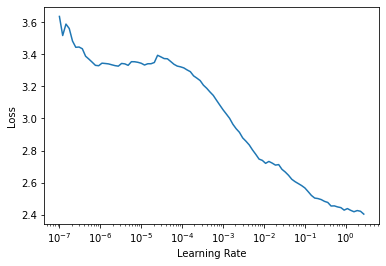

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, 1e-3,cbs=[CSVLogger(fname='resunetfull.csv',append=False),SaveModelCallback(monitor='mIOU',fname='resunetfull')])

epoch,train_loss,valid_loss,mIOU,time
0,13.101887,13.305848,0.278248,06:45
1,7.941946,7.924438,0.291747,07:07
2,4.483730,4.349717,0.311456,07:08
3,3.218871,3.178202,0.312693,07:09
4,3.591551,3.381716,0.259240,07:06
5,3.538093,3.558683,0.277935,06:38
6,3.522654,3.216450,0.295584,06:38
7,3.438357,3.323000,0.314286,06:38
8,3.442456,3.418908,0.308673,06:38
9,3.394341,3.443408,0.302147,06:38


Better model found at epoch 0 with mIOU value: 0.2782482623136581.
Better model found at epoch 1 with mIOU value: 0.2917466496236728.
Better model found at epoch 2 with mIOU value: 0.31145583808422345.
Better model found at epoch 3 with mIOU value: 0.3126932801424088.
Better model found at epoch 7 with mIOU value: 0.3142861891935157.


In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_x=ColReader('path'),
               get_y=ColReader('path'),
               splitter=ColSplitter('valid'),
               item_tfms=[augb,aug2b]
              )

# db.summary(source=df)

In [ ]:
dls = db.dataloaders(source=df,bs=6, num_workers=4)

In [ ]:
learn = Learner(dls,model,metrics=mIOU,loss_func=loss).to_fp16()

In [ ]:
learn.load('resunet')

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

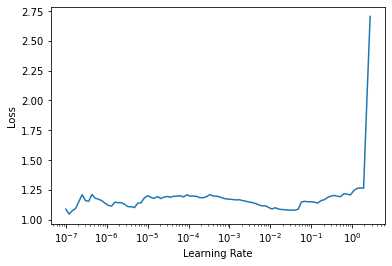

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, 1e-4,cbs=[CSVLogger(fname='resunetb.csv',append=True),SaveModelCallback(monitor='mIOU',fname='resunetb')])

epoch,train_loss,valid_loss,mIOU,time
0,1.099139,1.150839,0.297078,06:02
1,1.103459,1.102945,0.302756,05:58
2,1.012630,1.044157,0.307101,05:58
3,0.985338,1.035703,0.311624,05:58
4,0.957569,1.023964,0.312812,05:59
5,0.953731,0.979053,0.321467,05:59
6,0.963843,0.974124,0.321962,05:59
7,0.968543,0.988442,0.326042,05:59
8,0.953888,0.986929,0.325608,05:59
9,0.947728,0.982077,0.326625,05:59


Better model found at epoch 0 with mIOU value: 0.2970777580907724.
Better model found at epoch 1 with mIOU value: 0.30275627480773604.
Better model found at epoch 2 with mIOU value: 0.3071008773487382.
Better model found at epoch 3 with mIOU value: 0.311623554582974.
Better model found at epoch 4 with mIOU value: 0.312811778315522.
Better model found at epoch 5 with mIOU value: 0.32146691192833626.
Better model found at epoch 6 with mIOU value: 0.32196201334917124.
Better model found at epoch 7 with mIOU value: 0.32604187787558375.
Better model found at epoch 9 with mIOU value: 0.32662507003170005.
Better model found at epoch 10 with mIOU value: 0.3298108449453225.
Better model found at epoch 11 with mIOU value: 0.3304579811010217.
Better model found at epoch 13 with mIOU value: 0.3344901571825556.
Better model found at epoch 17 with mIOU value: 0.33690291149381896.
Better model found at epoch 22 with mIOU value: 0.3379249001527542.
Better model found at epoch 25 with mIOU value: 0.338

In [ ]:
def IOU( pred,label, num_classes=10):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()
    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        if sem_class!=30:
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
    return present_iou_list,np.mean(present_iou_list)

In [ ]:
learn.load('resunet')

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/test/')

In [ ]:
learn.model.eval()

In [ ]:
import skimage.io as skio

In [ ]:
for img in imgs:
    temp=RsImage.create(img)
    temp=val_pipe(image=temp.numpy())['image']
    with torch.no_grad():
        result=learn.model(temp.unsqueeze(0).cuda())
    result=F.avg_pool2d(result,2)
    result=result.argmax(axis=1)
    result=result[0]+1
    result=result.cpu().numpy().astype('uint8')
    newname='/home/staff/xin/Downloads/tianchi/resultV0/'+img.name.replace('tif','png')
    skio.imsave(newname,result)

In [ ]:
xx=skio.imread('/home/staff/xin/Downloads/tianchi/train/010000.png')

In [ ]:
import geopandas as gpd

In [ ]:
xx=gpd.read_file('/home/staff/xin/stationbasins.geojson')

In [ ]:
xx.to_file('/home/staff/xin/tan/chun')